<h3>Simulation of "single" photon detection</h3>

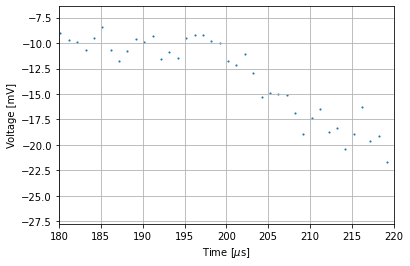

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from random import randint, uniform

def gen_signal(x=np.linspace(0,1000,2000), baseline=0, amplitude=140, rise_time=40, decay_time=60, pulse_start=200, noise_lev=0.5):
    signal = baseline+1*amplitude*(np.exp(-x/rise_time)-np.exp((-x/decay_time)))
    signal = np.interp(x, x+pulse_start, signal)
    noise = np.random.normal(scale=noise_lev, size=len(signal))

    return signal+noise

time = np.linspace(0,1000,1000)
#signal = gen_signal(baseline=-10, x=time)
signal = gen_signal(baseline=-10, x=time, amplitude=100, noise_lev=1)
noise = np.random.normal(scale=0.5, size=len(signal))
#clean_signal = gen_signal(baseline=-10, x=time, noise_lev=0)

plt.scatter(time, signal, marker='.', s=5)
#plt.scatter(time, clean_signal, color="r", marker='.', s=2)
plt.xlabel('Time [$\mu$s]')
plt.ylabel('Voltage [mV]')
plt.xlim(180, 220)
plt.grid()
plt.show()

<h4>Derivative Trigger</h4>

In [58]:
def derivative_trigger(sample, n=2, plot=False):
    i = 0
    # Initialize an empty list to store moving averages
    moving_averages = []
    window_size = 15
    
    # Loop through the array to consider
    # every window of size 3
    while i < len(sample) - window_size + 1:
        
        # Store elements from i to i+window_size
        # in list to get the current window
        window = sample[i : i + window_size]
    
        # Calculate the average of current window
        window_average = round(sum(window) / window_size, 2)
        
        # Store the average of current
        # window in moving average list
        moving_averages.append(window_average)
        
        # Shift window to right by one position
        i += 1


    first_derivative = np.gradient(moving_averages)
    plt.plot(time[0:len(first_derivative)], first_derivative)
    n_points, i = 0, 0
    std = np.std(first_derivative[0:100])/2 #100 will become a function of length and pos_ref in pxie
    index_min = first_derivative.argmin()

    #print('index_min = ', index_min)
    
    rise_points = 0
    while first_derivative[index_min - rise_points] < -std:
        rise_points += 1
    
    #print('rise_points = ', rise_points)

    ######
    #this part of the code could be used to check whether it's signal or noise
    #check is less than 10 for noise and more than 100 for signal (e.g. for cutoff: len(sample)/10)
    #check = 0
    #for i in range(len(sample)):
    #    check = check + 1 if (sample[i] < np.mean(sample[0:100])- 3*np.std(sample[0:100])) else check
    #
    #print(check)
    ######

    a = 10 #to have a window_length of 21, in this way all the windows are equal
    start = index_min - rise_points
    end = start + a +1     # +1 to avoid the error: "window_length must be odd."
    begin = start - a if start - a > 0 else 0 # To avoid negative values for begin
    
    #print('hint start = %d, begin = %d, end = %d' %(start, begin, end))
    
    window_length = len(sample[begin:end]) #-1 if len(sample[begin:end]) % 2 == 0 else len(sample[begin:end])

    #print(window_length)

    #poly_order = window_length-1 if window_length < 14 else 12
    
    derivative_func = savgol_filter(sample[begin:end], window_length, 8, n, delta=1) #8 is the best in the tests done
    b = a // 2
    # we have to drop the first b points and the last b points of the array
    # since sth strange happens here with the derivative due to the polinomial fitting of sav_gol
    if plot:
        plt.scatter(time[begin:end], savgol_filter(sample[begin:end], window_length, 8, 0, delta=1), color='dodgerblue')
        plt.scatter(time[begin+b:end-b], derivative_func[b:-b], color="g")
        plt.xlabel('Time [$\mu$s]')
        plt.ylabel('Voltage [mV]')
        plt.grid()
        plt.show()

    
    return derivative_func[b+derivative_func[b:-b].argmin()], begin+b+(derivative_func[b:-b].argmin())
    #return print('start: ', time[begin+b+derivative_func[b:-b].argmin()])

### Test to check the trigger
A random signal is generated 1k times and the output are plotted for a quick visualization of the results

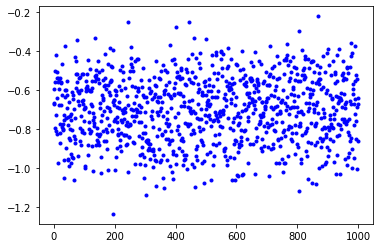

In [14]:
ind, sav = np.zeros(1000), np.zeros(1000)
for i in range(1000):
    ind[i], sav[i] = derivative_trigger(gen_signal(x          = np.linspace(0,1000,500), 
                                                   baseline   = -10, 
                                                   amplitude  = randint(100,200), 
                                                   decay_time = uniform(60,70),
                                                   pulse_start= 200,
                                                   noise_lev  = 0.5),
                                        n=2)
plt.scatter(np.linspace(0,1000,1000),ind, color="b", marker='.')
plt.show()

The approximated number of wrong evaluations is 1


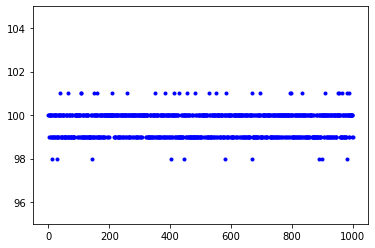

In [20]:
count = 0
for i in range(len(sav)):
    if sav[i] < sav.mean() - sav.std() or sav[i] > sav.mean() + sav.std():
        count += 1
print('The approximated number of wrong evaluations is %d' %count)
plt.scatter(np.linspace(0,1000,1000),sav, color="b", marker='.')
plt.ylim(95,105)
plt.show()

Considering how we have parametrized the signal, our goal point (the point where the derivative changes) should be around 200 microseconds. 

(-0.205862718398587, 184)

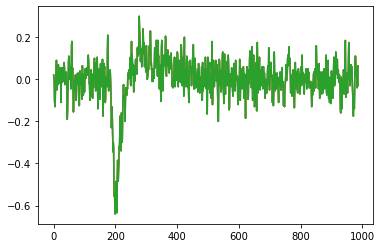

In [59]:
derivative_trigger(signal, n=0)
derivative_trigger(signal, n=1)
derivative_trigger(signal, n=2)

Comparison between np.diff and np.gradient

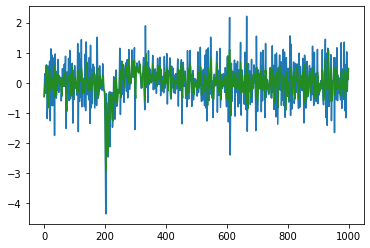

In [23]:
x = np.linspace(0,1000,500)
signal = gen_signal(x)
plt.plot(x[:len(x)-1], np.diff(signal))
plt.plot(x, np.gradient(signal), c='forestgreen')
plt.show()

### Alternative methods for the second derivative
Alternatives to sav_gol could be:
- np.diff
- np.gradient
- scipy.interpolate (splrep and splev)
- scipy.interpolate.UnivariateSpline 

In [11]:
from scipy.interpolate import splrep, splev, UnivariateSpline, InterpolatedUnivariateSpline

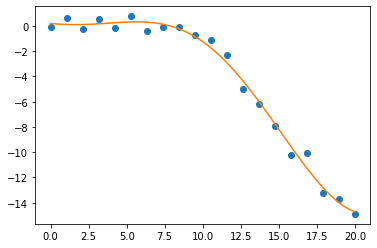

In [12]:
x = np.linspace(0, 20, 20)
signal = gen_signal(x= np.linspace(0, 1000, 500))
y= signal[90:110]
spl = splrep(x, y, k=5, s=5)
x2 = np.linspace(0, 20, 200)
y2 = splev(x2, spl)
plt.plot(x, y, 'o', x2, y2)
plt.show()

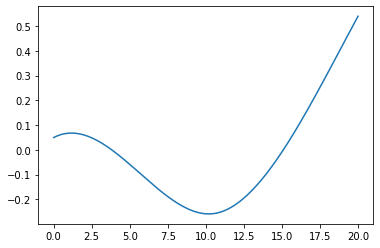

In [13]:
ddy = splev(x2,spl, der=2) # use those knots to get second derivative
#plt.plot(x, y, c='g')
plt.plot(x2, ddy)
plt.show()

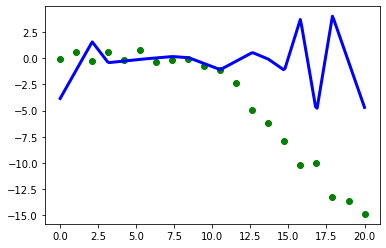

In [14]:
spl = UnivariateSpline(x, y)
plt.plot(x, y, 'go', lw=3)
spl.set_smoothing_factor(1.5)
der = spl.derivative(2)
plt.plot(x2, der(x2), 'b', lw=3)
plt.show()

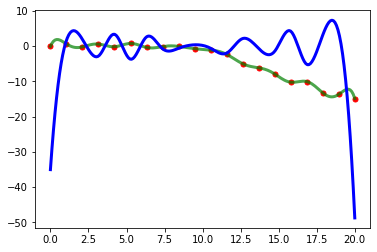

In [15]:
spl = InterpolatedUnivariateSpline(x, y, k=5)
plt.plot(x, y, 'ro', ms=5)
plt.plot(x2, spl(x2), 'g', lw=3, alpha=0.7)
der = spl.derivative(2)
plt.plot(x2, der(x2), 'b', lw=3)
plt.show()